# Final Project - Part 4 | Test

- For at least one selected model
    - further tune hyperparameters. 
    - If feasible consider combining models. 
    - Use test data to test the model. 
    - Create a report of the adjustments and results. 
        - Report should also include suggestions for further work on the project.

# Approach

From our final project part 3, we uncovered that LSTM has a possibility to perform well on our predictions for future price data. We found that our best results for our LSTM model was when the time sequences were set to a 20 day rolling window. Below are also the details of the LSTM model parameters:

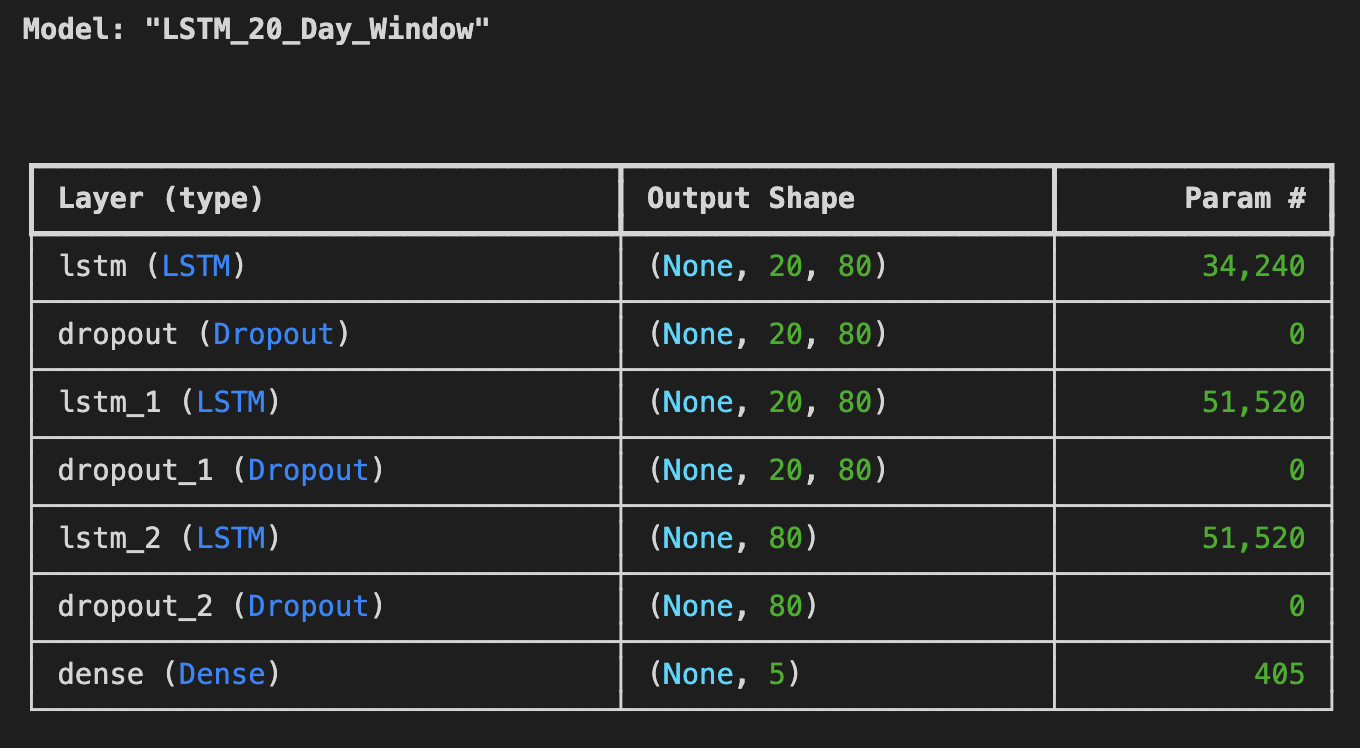

Also, we found that kmeans performed well when conducting clustering on the same 20 day rolling window, PCA of 2 components, and finally a K value of 2. 

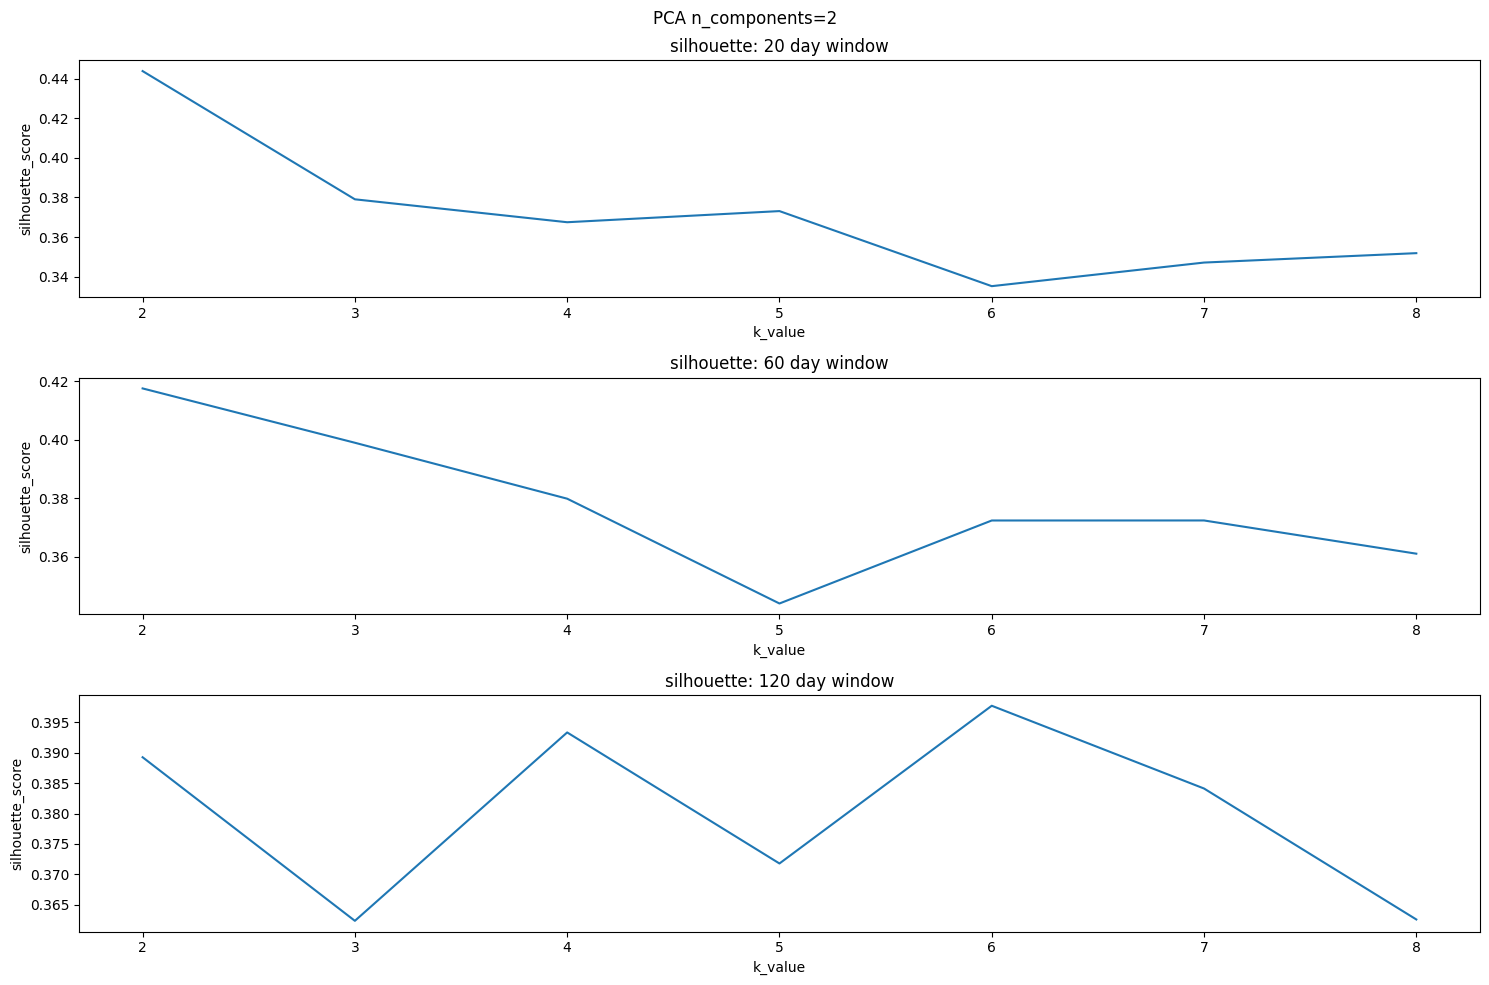

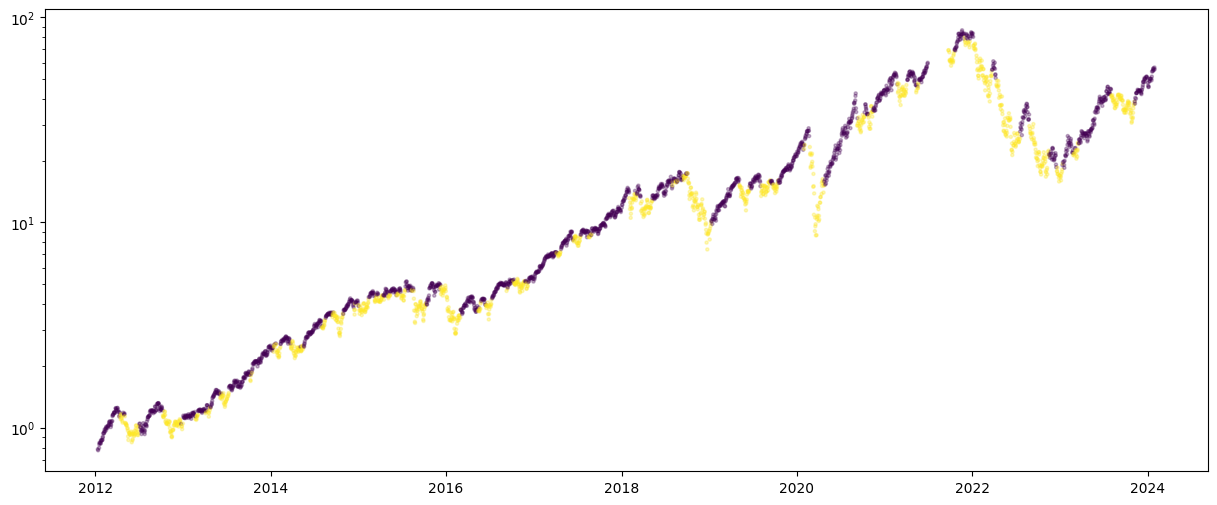

Considering all of this, we will use a combination of both models to really fine tune our results and hopefully yield something that is promising.

- First, we will normalize the data in preparation for kmeans and LSTM
- Second, we will explore more details in the hyperparameter tuning of kmeans in an attempt to increase the silhouette score for the model
- Third, we will train the model on training set and conduct predictions on the test set in order to predict what cluster that the observation falls under
- Fourth, we will conduct hyperparameterization on the RNN LSTM model in an attempt to decrease the MSE results and attempt to better predict future prices with the addition ofthe kmeans clustering results
- Finally, once we have completed hyperparameterization, we will run some test data predict the outcomes and document our findings.

# ETL

In [55]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# upload data function
from data_etl_rnn_prep import execute_etl
from data_etl_rnn_prep import *
import copy

# kmeans imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# !pip3 install optuna
import optuna

# RNN LSTM imports
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout
from keras import backend as K
from sklearn.decomposition import PCA

In [3]:
# upload required data 
df = execute_etl('2010-12-31', '2024-02-29', 'TQQQ')
df_copy = copy.deepcopy(df)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
# using the date index for standardizing the data
df_date_idx = df_copy.set_index('Date')

# cols to remove for rnn
rmv_cols = [
    'decision',
    'cash',
    'cash_ret',
    'initial_hold_days',
    'hold_countdown'
]
df_rnn_kmeans = df_date_idx.drop(columns=rmv_cols)

In [5]:
# set x and y for rnn
x_rnn_kmeans = df_rnn_kmeans.iloc[:, :-5]
y_rnn_kmeans = df_rnn_kmeans.iloc[:, -5:]

# list with column names 
x_cols = list(x_rnn_kmeans.columns.values)
y_cols = list(y_rnn_kmeans.columns.values)

In [6]:
# splitting data between train and test sets
x_train = x_rnn_kmeans[x_rnn_kmeans.index < '2021-06-30']
x_test = x_rnn_kmeans[x_rnn_kmeans.index >= '2021-06-30']

y_train = y_rnn_kmeans[y_rnn_kmeans.index < '2021-06-30']
y_test = y_rnn_kmeans[y_rnn_kmeans.index >= '2021-06-30']

In [7]:
# define window size
window_size = 20

# apply the feature scaling for trainand test data
x_train_normalized, x_train_min_max_values, y_train_normalized, y_train_min_max_values = apply_feature_scaling(window_size, x_train, y_train, training_set=True)
x_test_normalized, x_test_min_max_values, y_test_normalized, y_test_min_max_values = apply_feature_scaling(window_size, x_test, y_test, training_set=True)

# Hyperparameterization for KMeans

First we will implement the kmeans algorithm that was used in part 3 of our project to establish a baseline

In [8]:
pca = PCA(n_components=2)

x_kmeans_20_pca2 = pca.fit_transform(x_train_normalized)

# kmeans for 20 day window
score_20 = []

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(x_kmeans_20_pca2)
score = silhouette_score(x_kmeans_20_pca2, labels)
score_20.append(score)

print(f'silhouette score: {score_20}')

silhouette score: [0.4528905586154439]


In [9]:
# implementing optimization algorithm for kmeans using 
def objective(trial):
    n_clusters = trial.suggest_int('n_clusters', 2, 10)
    init = trial.suggest_categorical('init', ['k-means++', 'random'])
    n_init = trial.suggest_int('n_init', 5, 20)
    
    kmeans_optimize = KMeans(n_clusters=n_clusters, init=init, n_init=n_init, random_state=42)
    kmeans_optimize.fit(x_kmeans_20_pca2)
    silhouette_avg = silhouette_score(x_kmeans_20_pca2, kmeans_optimize.labels_)
    
    return silhouette_avg

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Best parameters:', study.best_params)
print('Best silhouette score:', study.best_value)

[I 2024-04-14 16:14:04,205] A new study created in memory with name: no-name-8100051e-196e-4a43-b256-fd47ee5ed266
[I 2024-04-14 16:14:04,455] Trial 0 finished with value: 0.3506715144905259 and parameters: {'n_clusters': 8, 'init': 'k-means++', 'n_init': 5}. Best is trial 0 with value: 0.3506715144905259.
[I 2024-04-14 16:14:04,765] Trial 1 finished with value: 0.4528905586154439 and parameters: {'n_clusters': 2, 'init': 'random', 'n_init': 15}. Best is trial 1 with value: 0.4528905586154439.
[I 2024-04-14 16:14:05,052] Trial 2 finished with value: 0.4528905586154439 and parameters: {'n_clusters': 2, 'init': 'k-means++', 'n_init': 14}. Best is trial 1 with value: 0.4528905586154439.
[I 2024-04-14 16:14:05,250] Trial 3 finished with value: 0.4528905586154439 and parameters: {'n_clusters': 2, 'init': 'random', 'n_init': 7}. Best is trial 1 with value: 0.4528905586154439.
[I 2024-04-14 16:14:05,531] Trial 4 finished with value: 0.3480057676803452 and parameters: {'n_clusters': 7, 'init': 

Best parameters: {'n_clusters': 2, 'init': 'k-means++', 'n_init': 15}
Best silhouette score: 0.4529468932426564


We can see here that even after running this optimization algorithm, we still end up with a silhouette score near our original score. We attempted to make some changes to the parameters by setting a large range of clusters to determine if there were any unforseen better optimized clusters in the larger range. Set the optoins for k-means++ and random, which essentailly affects the rate of convergence. However, the default option for convergence, k-means++, is already the most optimized option for convergence compared with the random option, which sets observations at random from the data for the initial centroids. We also tested a range of parameters for n_init, which id the number of times that the algorithm runs with different centroid seeds. A larger value of n_init can yield greater stability and quality of clusters but may take more time.

## Join Labels to x_train

In [15]:
labels_df = pd.DataFrame(labels, columns=['cluster'], index=x_train_normalized.index)
x_train_normalized = x_train_normalized.merge(labels_df, left_index=True, right_index=True)
x_train_normalized

,TQQQ_close_scaled,TQQQ_volume_scaled,TQQQ_ret_scaled,tbf_close_scaled,tbf_volume_scaled,tbf_ret_scaled,tip_close_scaled,tip_volume_scaled,tip_ret_scaled,uup_close_scaled,...,uso_ret_scaled,gld_close_scaled,gld_volume_scaled,gld_ret_scaled,TQQQ_35_day_ema_scaled,TQQQ_200_day_sma_scaled,TQQQ_macd_scaled,TQQQ_macd_signal_scaled,TQQQ_rsi_scaled,cluster
Date,,,,,,,,,,,,,,,,,,,,,
2011-11-14,0.340933,0.000000,0.469836,0.163121,0.181723,0.315265,0.802246,0.000000,0.434364,0.841465,...,0.221178,0.896572,0.000000,0.216935,1.000000,0.0,0.000000,0.472379,0.116476,0
2011-11-15,0.580771,0.382430,0.736769,0.166668,0.231132,0.537111,0.686676,0.155173,0.163230,1.000000,...,0.568118,0.905869,0.202008,0.343483,1.000000,0.0,0.024593,0.275509,0.218623,0
2011-11-16,0.201190,0.461016,0.294221,0.074471,0.093374,0.422362,0.601920,0.071913,0.215973,1.000000,...,0.673294,0.798373,0.566774,0.066239,0.996366,0.0,0.000000,0.015852,0.000000,0
2011-11-17,0.000000,1.000000,0.188384,0.000000,0.219931,0.408617,0.599355,0.104969,0.358692,1.000000,...,0.000000,0.490298,1.000000,0.000000,0.925277,0.0,0.000000,0.000000,0.000000,0
2011-11-18,0.000000,0.369815,0.431734,0.003448,0.000000,0.537181,0.569586,0.074711,0.376561,0.934783,...,0.238248,0.472779,0.366943,0.532858,0.810406,0.0,0.000000,0.000000,0.048740,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-23,1.000000,0.332727,0.401059,0.279568,0.105921,0.613533,0.770352,0.162492,0.638190,0.812501,...,0.585505,0.087428,0.120438,0.699700,1.000000,1.0,1.000000,1.000000,1.000000,1
2021-06-24,1.000000,0.329333,0.602661,0.258065,0.107162,0.504899,0.592570,0.044060,0.493258,0.781250,...,0.481738,0.080202,0.046778,0.701090,1.000000,1.0,1.000000,1.000000,0.926058,1
2021-06-25,0.980495,0.259455,0.342168,0.419355,0.040204,0.812528,0.688893,0.118496,0.692025,0.796874,...,0.646677,0.119942,0.073519,0.792148,1.000000,1.0,1.000000,1.000000,0.791157,1


# Hyperparameterization for LSTM

This new x_train_normalized data will be used in our LSTM RNN as a new feature that can hopefully improve the MSE for our model

In [17]:
# function to apply trained kmeans on testing data
def run_kmeans(kmeans, pca, x_test_data_normalized):
    data_pca = pca.transform(x_test_data_normalized)
    labels = kmeans.predict(data_pca)
    labels_df = pd.DataFrame(labels, columns=['cluster'], index=x_test_data_normalized.index)
    x_test_data_normalized = x_test_data_normalized.merge(labels_df, left_index=True, right_index=True)

    return x_test_data_normalized

In [19]:
# reshaping data for RNN LSTM model
x_rnn_train_reshape_20, y_rnn_train_reshape_20 = re_shape_df(20, x_train_normalized, y_train_normalized, train_set=True)

shape of x: (2401, 20, 27)
shape of y: (2401, 5)


In [22]:
# apply kmeans to x_test
x_test_normalized = run_kmeans(kmeans, pca, x_test_normalized)
x_rnn_test_reshape_20, y_rnn_test_reshape_20 = re_shape_df(20, x_test_normalized, y_test_normalized, train_set=True)

shape of x: (611, 20, 27)
shape of y: (611, 5)


Now, we will use the original parameters for our LSTM model to determine if the addition of kmeans to the model improves it's performance

In [23]:
# applying the LSTM model 
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout
from keras import backend as K
from tensorflow.keras.optimizers import Adam

K.clear_session()

model_20 = Sequential(name='LSTM_20_Day_Window')
model_20.add(
    LSTM(
        units=80, activation='tanh',
        input_shape=(x_rnn_train_reshape_20.shape[1], x_rnn_train_reshape_20.shape[2]),
        return_sequences=True
    )
)
model_20.add(
    Dropout(
        0.20
    )
)
model_20.add(
    LSTM(
        units=80, activation='tanh',
        input_shape=(x_rnn_train_reshape_20.shape[1], x_rnn_train_reshape_20.shape[2]),
        return_sequences=True
    )
)
model_20.add(
    Dropout(
        0.20
    )
)
model_20.add(
    LSTM(
        units=80, activation='tanh',
        input_shape=(x_rnn_train_reshape_20.shape[1], x_rnn_train_reshape_20.shape[2])
    )
)
model_20.add(
    Dropout(
        0.20
    )
)
model_20.add(
    Dense(
        5,
        activation='linear'
    )
)

model_20.compile(
    optimizer='adam',
    loss='mse'
)

# get a summary of model parameters
model_20.summary()

# train the model
model_20.fit(
    x_rnn_train_reshape_20,
    y_rnn_train_reshape_20,
    epochs=50,
    batch_size=28
)

Model: "LSTM_20_Day_Window"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 80)         │        34,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 80)         │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 80)             │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,005 (539.08 KB)

 Trainable params: 138,005 (539.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1917
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1089
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1011
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0913
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0852
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0784
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0733
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0691
Epoch 9/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0642
Epoch 10/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0588
Epoch 11/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0526
Epoch 12/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0485
Epoch 13/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0463
Epoch 14/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0444
Epoch 15/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0418
Epoc

In [24]:
# evaluate the model
performance_20 = model_20.evaluate(x_rnn_test_reshape_20, y_rnn_test_reshape_20)
print("Model performance: ", performance_20)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1998 
Model performance:  0.2084609568119049


It doesn't seem like the new kmeans parameter increased the performance of the model. We will conduct more more instances of the model with different parameters. Below, I am going to be conduct the same LSTM but with a larger number of epochs to see where we receive a more definite convergence range. 

In [25]:
K.clear_session()

model_20 = Sequential(name='LSTM_20_Day_Window')
model_20.add(
    LSTM(
        units=80, activation='tanh',
        input_shape=(x_rnn_train_reshape_20.shape[1], x_rnn_train_reshape_20.shape[2]),
        return_sequences=True
    )
)
model_20.add(
    Dropout(
        0.20
    )
)
model_20.add(
    LSTM(
        units=80, activation='tanh',
        input_shape=(x_rnn_train_reshape_20.shape[1], x_rnn_train_reshape_20.shape[2]),
        return_sequences=True
    )
)
model_20.add(
    Dropout(
        0.20
    )
)
model_20.add(
    LSTM(
        units=80, activation='tanh',
        input_shape=(x_rnn_train_reshape_20.shape[1], x_rnn_train_reshape_20.shape[2])
    )
)
model_20.add(
    Dropout(
        0.20
    )
)
model_20.add(
    Dense(
        5,
        activation='linear'
    )
)

model_20.compile(
    optimizer='adam',
    loss='mse'
)

# get a summary of model parameters
model_20.summary()

# train the model
model_20.fit(
    x_rnn_train_reshape_20,
    y_rnn_train_reshape_20,
    epochs=150,
    batch_size=28
)

# evaluate the model
performance_20 = model_20.evaluate(x_rnn_test_reshape_20, y_rnn_test_reshape_20)
print("Model performance: ", performance_20)

Model: "LSTM_20_Day_Window"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 80)         │        34,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 80)         │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 80)             │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,005 (539.08 KB)

 Trainable params: 138,005 (539.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1841
Epoch 2/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1059
Epoch 3/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0969
Epoch 4/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0914
Epoch 5/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0865
Epoch 6/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0764
Epoch 7/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0769
Epoch 8/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0690
Epoch 9/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0607
Epoch 10/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0582
Epoch 11/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0522
Epoch 12/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0496
Epoch 13/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0467
Epoch 14/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0433
Epoch 15/150
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - lo

These results are still not assignificant as we would like. We will try using a hyperparameter tunning package through keras called keras_tuner. 

In [30]:
# !pip3 install keras_tuner
import keras_tuner as kt

K.clear_session()

def build_model(hp):
    model = Sequential(name='LSTM_20_Day_Window')
    model.add(LSTM(
        units=hp.Int('units', min_value=20, max_value=200, step=10),
        activation='tanh',
        input_shape=(x_rnn_train_reshape_20.shape[1], x_rnn_train_reshape_20.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(
        units=hp.Int('units', min_value=20, max_value=200, step=10),
        activation='tanh',
        return_sequences=True
    ))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(
        units=hp.Int('units', min_value=20, max_value=200, step=10),
        activation='tanh'
    ))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(5, activation='linear'))
    
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='mse'
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # number of configurations to try
    executions_per_trial=1,  # number of models to build for each trial
    directory='my_dir',
    project_name='lstm_hyperopt'
)

tuner.search(x_rnn_train_reshape_20, y_rnn_train_reshape_20, epochs=50, validation_split=0.2)

Trial 10 Complete [00h 02m 29s]
val_loss: 0.0829847976565361

Best val_loss So Far: 0.08089448511600494
Total elapsed time: 00h 19m 50s


In [31]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The best number of units in the LSTM layers: {best_hps.get('units')}")
print(f"The best dropout rate: {best_hps.get('dropout_1')}")
print(f"The best optimizer: {best_hps.get('optimizer')}")

# setting the best model to a variable
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
test_loss = best_model.evaluate(x_rnn_test_reshape_20, y_rnn_test_reshape_20)
print(f'Best Model Test Loss: {test_loss}')

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions
predictions = best_model.predict(x_rnn_test_reshape_20)

# Calculate MSE and MAE
mse = mean_squared_error(y_rnn_test_reshape_20, predictions)
print(f'mse: {mse}')

The best number of units in the LSTM layers: 170
The best dropout rate: 0.5
The best optimizer: rmsprop
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1337
Best Model Test Loss: 0.12416800111532211
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
mse: 0.12794881990493165


In [32]:
best_model.summary()

Model: "LSTM_20_Day_Window"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 170)        │       134,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 170)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 170)        │       231,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 170)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 170)            │       231,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 170)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 599,255 (2.29 MB)

 Trainable params: 599,255 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# getting min max col values 
min_cols = [col for col in y_test_min_max_values.columns if 'min' in col]
max_cols = [col for col in y_test_min_max_values.columns if 'max' in col]

# un scaling the prediction results
y_pred_20_df = pd.DataFrame(predictions, columns=y_cols)
y_pred_20_df_inv_scaled = reverse_rolling_window_scaling(predictions, np.array(y_test_min_max_values[min_cols].iloc[-len(predictions):]), np.array(y_test_min_max_values[max_cols].iloc[-len(predictions):]))
y_pred_20_df_inv_scaled = pd.DataFrame(y_pred_20_df_inv_scaled, columns=y_cols)
y_pred_20_df_inv_scaled.set_index(y_test.index[-len(predictions):], inplace=True)
y_pred_20_df_inv_scaled

,TQQQ_1_day_close,TQQQ_3_day_close,TQQQ_5_day_close,TQQQ_10_day_close,TQQQ_20_day_close
Date,,,,,
2021-08-25,67.811204,69.106944,69.882448,69.982467,71.341000
2021-08-26,69.438417,70.100837,70.657485,70.455141,71.192737
2021-08-27,71.575316,70.436905,71.259340,70.601801,71.057146
2021-08-30,71.986119,70.754925,71.755712,70.790786,69.860870
2021-08-31,72.736234,71.600612,72.079076,70.994559,69.589826
...,...,...,...,...,...
2024-01-24,53.975354,52.804341,53.106342,54.556889,57.414817
2024-01-25,54.423729,53.223055,53.515815,54.988889,57.458099
2024-01-26,55.075090,53.431818,53.942954,56.323941,57.509127


#### MSE of Un-Scaled Predicted Results

In [52]:
print(f'MSE for 20 day window, 1 day close: {((y_test.iloc[-len(y_pred_20_df_inv_scaled):, 0] - y_pred_20_df_inv_scaled.iloc[:, 0])**2).sum()/len(y_pred_20_df_inv_scaled)}')
print(f'MSE for 20 day window, 3 day close: {((y_test.iloc[-len(y_pred_20_df_inv_scaled):, 1] - y_pred_20_df_inv_scaled.iloc[:, 1])**2).sum()/len(y_pred_20_df_inv_scaled)}')
print(f'MSE for 20 day window, 5 day close: {((y_test.iloc[-len(y_pred_20_df_inv_scaled):, 2] - y_pred_20_df_inv_scaled.iloc[:, 2])**2).sum()/len(y_pred_20_df_inv_scaled)}')
print(f'MSE for 20 day window, 10 day close: {((y_test.iloc[-len(y_pred_20_df_inv_scaled):, 3] - y_pred_20_df_inv_scaled.iloc[:, 3])**2).sum()/len(y_pred_20_df_inv_scaled)}')
print(f'MSE for 20 day window, 20 day close: {((y_test.iloc[-len(y_pred_20_df_inv_scaled):, 4] - y_pred_20_df_inv_scaled.iloc[:, 4])**2).sum()/len(y_pred_20_df_inv_scaled)}')

MSE for 20 day window, 1 day close: 10.387939869342365
MSE for 20 day window, 3 day close: 13.633824648833965
MSE for 20 day window, 5 day close: 20.822151599782917
MSE for 20 day window, 10 day close: 23.15540902811913
MSE for 20 day window, 20 day close: 29.402208722379402


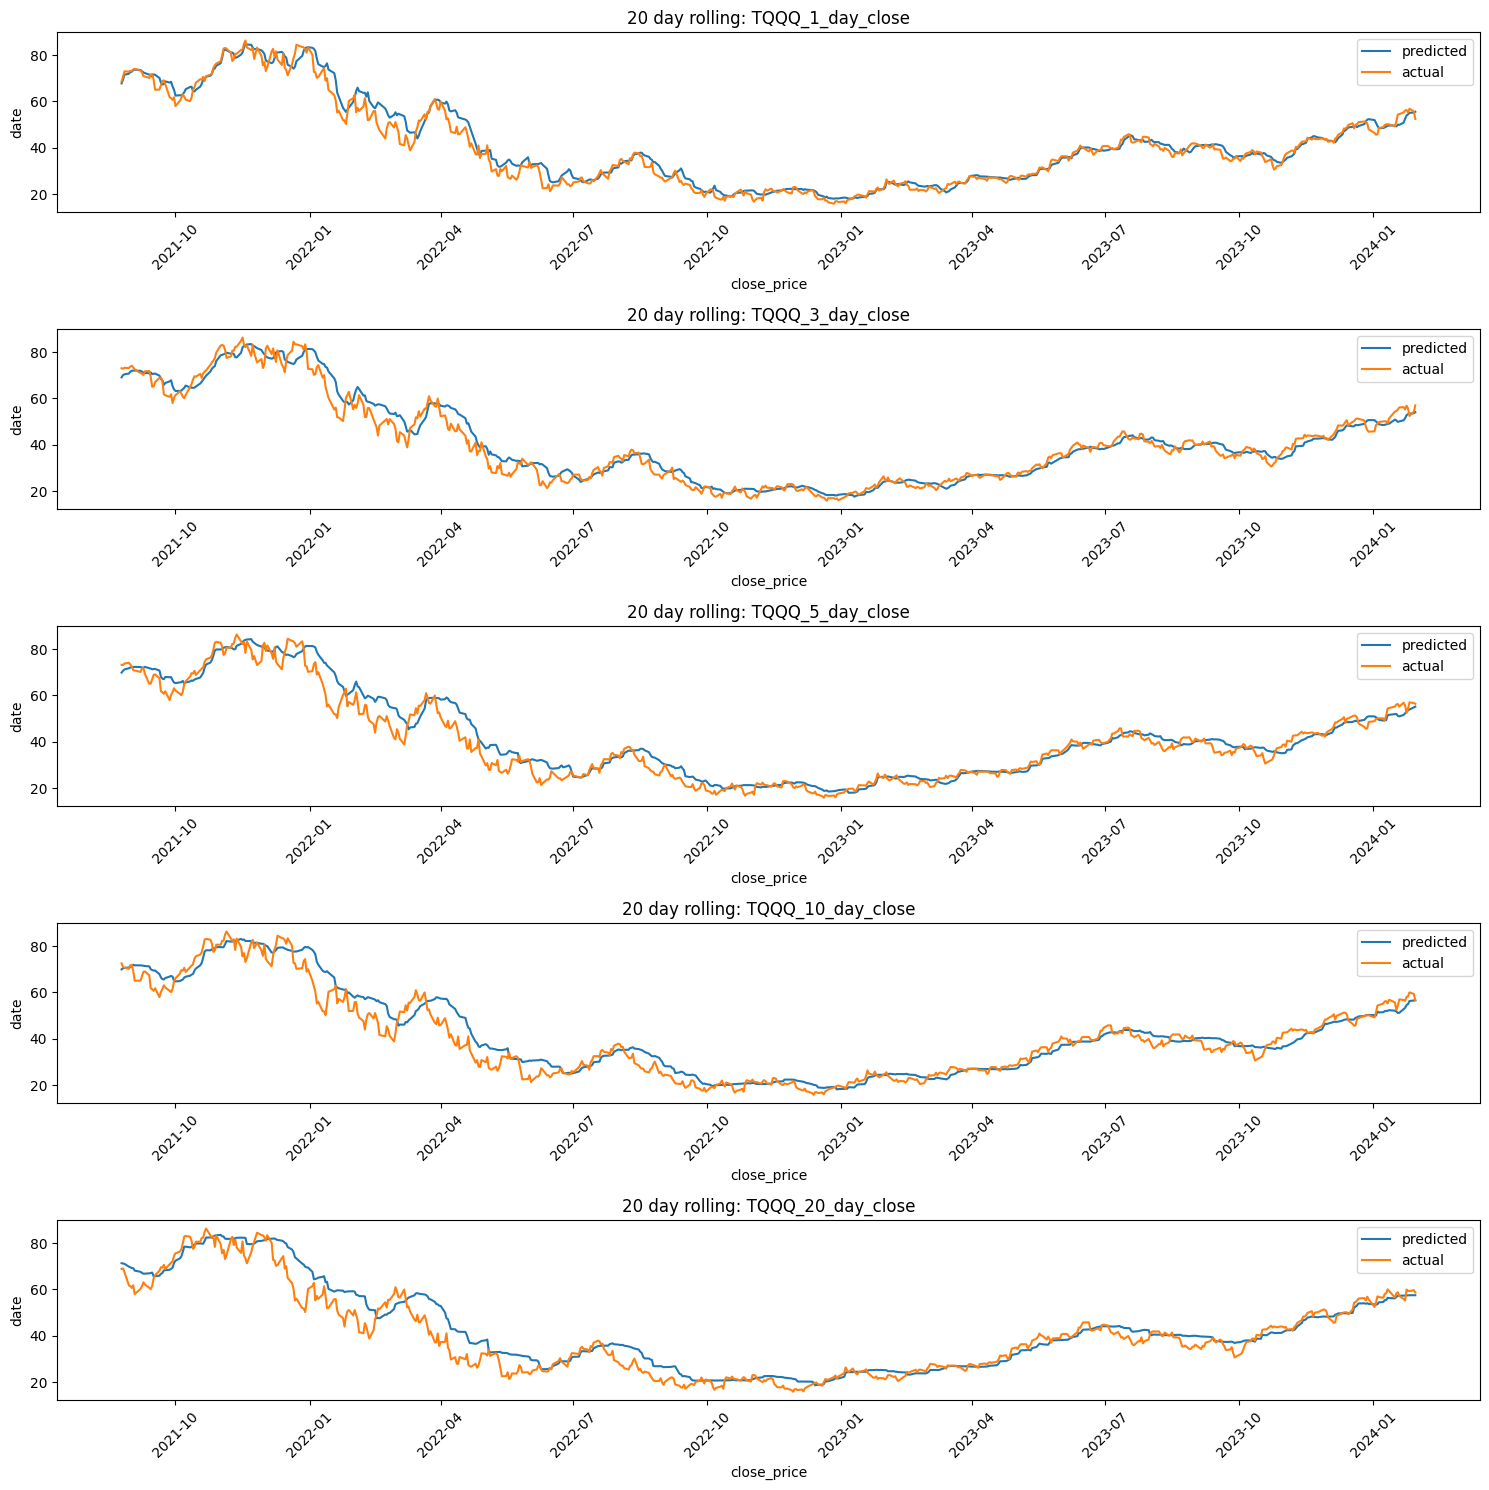

In [60]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15))

for col in range(len(y_pred_20_df_inv_scaled.columns)):
    axs[col].plot(
        y_pred_20_df_inv_scaled.iloc[:, col],
        label='predicted'
    )
    axs[col].plot(
        y_test.iloc[-len(y_pred_20_df_inv_scaled):, col],
        label='actual'
    )
    axs[col].set_xlabel('close_price')
    axs[col].set_ylabel('date')
    axs[col].set_title(f'20 day rolling: {y_pred_20_df_inv_scaled.columns[col]}')
    axs[col].legend()
    axs[col].tick_params(axis='x', rotation=45)

# axs.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [53]:
y_pred_20_df_inv_scaled.columns

Index(['TQQQ_1_day_close', 'TQQQ_3_day_close', 'TQQQ_5_day_close',
       'TQQQ_10_day_close', 'TQQQ_20_day_close'],
      dtype='object')